<a href="https://colab.research.google.com/github/Howuhh/dul_2021/blob/hw10/Homework/hw10/Homework10_selfsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 339, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (110/110), done.
remote: Total 339 (delta 100), reused 78 (delta 60), pack-reused 163
Receiving objects: 100% (339/339), 55.19 MiB | 26.01 MiB/s, done.
Resolving deltas: 100% (157/157), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=25374 sha256=6a2f4ca2b3786d791b32485cd2fa2602a311e3c14ad204977b5f8ecb47ce4005
  Stored in directory: /tmp/pip-ephem-wheel-cache-jl1y73_4/wheels/55/59/29/0fb1c6356521

In [1]:
from dul_2021.utils.hw10_utils import *

In [2]:
!nvidia-smi

Tue Feb  8 21:26:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    63W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Question 1. Context Encoder

Here we will implement [context encoder](https://arxiv.org/abs/1604.07379). The context encoder structures its self-supervised learning task by inpainting masked images. For example, the figure below shows different masking shapes, such as center masking, random block masking, and segmentation masking. Note that segmentation masking (c) is not purely self-supervised since we would need to train a image segmentation model which requires labels. However, the other two masking schemes (a) and (b) and purely self-supervised.

![](https://drive.google.com/uc?id=1fhzkULYTtyMGUUF2n9dlPayJSdcY5pRv)

More formally, the context encoder optimizes the following reconstruction loss:
$$\mathcal{L}_{rec} = \left\Vert \hat{M} \odot (x - F((1 - \hat{M})\odot x)) \right\Vert^2_2$$
where $\hat{M}$ is the masked region, $x$ is the image, and $F$ is the context encoder that tries to reconstruct the masked portion. In addition to the reconstruction loss, the paper introduces an adversarial loss that encourages more realistic inpaintings.
$$L_{adv} = \max_D \mathbb{E}_{x\in \chi} [\log(D(x)) + \log(1 - D(F((1-\hat{M})\odot x)))]$$

In this task we will crop central 14x14 region. You can use slightly afjusted architectures from AVB task from homework 8.

**Hyperparametrs**

* latent_dim = 128
* epochs ~ 10-20
* classifier need fewer updates than encoder-decoder part. We suggest to update it on each 10-th iteration.

**You will provide the following deliverables**


1. Over the course of training, record the mse loss and adversarial losses per batch.
3. 30 (1, 28, 28) images. Where first 10 images are random sample from testdata with removed central region. Next 10 images are reconstracted images with your trained model. Last 10 images are initial without any removal.

In [3]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.optim as optim

from tqdm.auto import trange, tqdm
from torch.utils.data import Dataset, DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def create_mask(imgs, crop_height=14, crop_width=14):
    batch_size, _, h, w = imgs.shape
    mask = torch.zeros_like(imgs)

    h_idxs = np.random.randint(0, h - crop_height, size=batch_size)
    w_idxs = np.random.randint(0, w - crop_width, size=batch_size)

    for img_mask, h_idx, w_idx in zip(mask, h_idxs, w_idxs):
        img_mask[:, h_idx:(h_idx + crop_height), w_idx:(w_idx + crop_width)] = 1.0

    return mask

class Discriminator(nn.Module): 
    def __init__(self, hidden_dim): 
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1, 1), 
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1), 
            nn.ReLU()
        )
        self.linear = nn.Sequential(
            nn.Linear(4 * 4 * 128, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), 
            nn.ReLU(),
            nn.Linear(hidden_dim, 1), 
            nn.Sigmoid()
        )

    def forward(self, x): 
        out = self.linear(
            self.model(x).flatten(1)
        )
        return out

class Encoder(nn.Module): 
    def __init__(self, latent_dim): 
        super().__init__()
        self.encoder = nn.Sequential( 
            nn.Conv2d(1, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(), 
            nn.Conv2d(128, 128, 3, 2, 1),
            nn.ReLU()
        )
        self.linear = nn.Linear(4 * 4 * 128, latent_dim)

    def forward(self, x): 
        out = self.linear(
            self.encoder(x).flatten(1)
        )
        return out


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 3, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(128, 64, 4, 2, 1), 
            nn.ReLU(), 
            nn.ConvTranspose2d(64, 32, 4, 2, 1), 
            nn.ReLU(), 
            nn.Conv2d(32, 1, 3, 1, 1),
            nn.Tanh()
        )
        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128), 
            nn.ReLU()
        )

    def forward(self, x):
        out = self.decoder(
            self.linear(x).view(-1, 128, 4, 4)
        )
        return out

In [28]:
class ContextEncoder(nn.Module):
    def __init__(self, latent_dim, crop_size, discriminator_update=5):
        super().__init__()
        self.discriminator = Discriminator(hidden_dim=latent_dim)
        self.encoder = Encoder(latent_dim=latent_dim)
        self.decoder = Decoder(latent_dim=latent_dim)

        self.crop_size = crop_size
        self.eps = 1e-8
        self.discriminator_update = discriminator_update

    def forward(self, x):
        return self.decoder(self.encoder(x))

    def __loss(self, batch):
        mask = create_mask(batch, *self.crop_size)
        recon_batch = self.forward((1 - mask) * batch)

        # recon_loss
        mse_loss = mask * F.mse_loss(recon_batch, batch, reduction="none")
        mse_loss = mse_loss.mean() 
        
        discr_fake = self.discriminator(recon_batch)
        recon_loss = mse_loss + F.binary_cross_entropy(discr_fake, torch.ones_like(discr_fake))

        # adversarial loss
        discr_real = self.discriminator(batch)
        discr_fake = self.discriminator(recon_batch.detach())

        loss_real = F.binary_cross_entropy(discr_real, torch.ones_like(discr_real)) 
        loss_fake = F.binary_cross_entropy(discr_fake, torch.zeros_like(discr_fake))
        adv_loss = loss_real + loss_fake

        return recon_loss, adv_loss, mse_loss

    def fit(self, train_dataloader, lr, num_epochs):
        self.train() 
        
        gen_optim = optim.Adam(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=lr)
        dis_optim = optim.Adam(self.discriminator.parameters(), lr=lr)

        mse_losses, adv_losses = [], []
        step = 0.0
        for _ in trange(num_epochs, desc="Training"):
            for batch in tqdm(train_dataloader, desc="Epoch", leave=False):
                step = step + 1
                batch = batch.to(device)
                
                recon_loss, adv_loss, mse_loss = self.__loss(batch)
              
                gen_optim.zero_grad()
                dis_optim.zero_grad()
                recon_loss.backward()
                gen_optim.step()

                if step % self.discriminator_update == 0:
                    adv_loss.backward()
                    dis_optim.step()
                  
                mse_losses.append(mse_loss.item())
                adv_losses.append(adv_loss.item())

        return np.array(mse_losses), np.array(adv_losses)

    @torch.no_grad()
    def examples(self, x): 
        self.eval()
        x = torch.tensor(x, dtype=torch.float).to(device)
        mask = create_mask(x, *self.crop_size)
        
        x_mask = (1 - mask) * x
        x_recon = self.forward(x_mask)

        examples = np.vstack((
            x_mask.detach().cpu().numpy(), 
            x_recon.detach().cpu().numpy(), 
            x.detach().cpu().numpy()
        ))
        return examples

In [29]:
def q1(train_data, test_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    test_data: An (n_test, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1

    Returns
    - a (# of training iterations, ) numpy array of full of mse losses
    - a (# of training iterations, ) numpy array of full of adversarial losses
    - a (30, 1, 28, 28) numpy array of 10 transformed images, 10 reconstructions, and 10 groundtruths
    """
    train_data = ((train_data.data.unsqueeze(1) / 255) * 2 - 1).float()
    train_dataloader = DataLoader(train_data, batch_size=128, shuffle=True, pin_memory=True)

    model = ContextEncoder(latent_dim=128, crop_size=(14, 14), discriminator_update=10).to(device)
    mse_losses, adv_losses = model.fit(train_dataloader, num_epochs=10, lr=1e-4)

    test_data = ((test_data.data.unsqueeze(1) / 255) * 2 - 1).float()[np.random.choice(len(test_data), size=10, replace=False)]
    examples = model.examples(test_data)
    
    return mse_losses, adv_losses, examples

Training:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch:   0%|          | 0/469 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


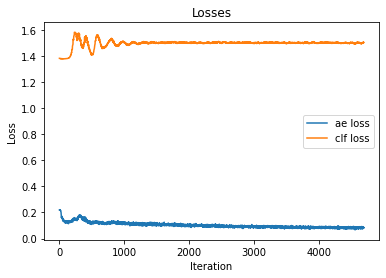

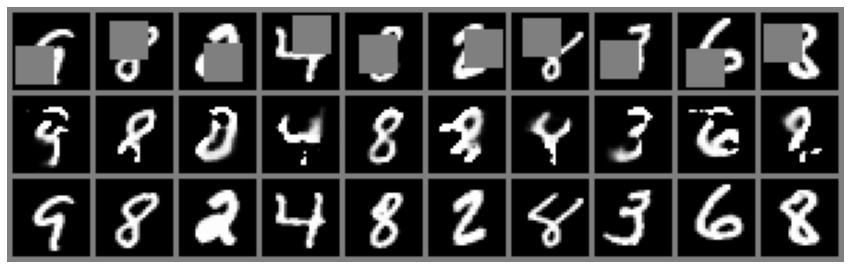

In [30]:
q1_results(q1)

# Question 2. Rotations Prediction

Here we will imlement this [paper](https://arxiv.org/abs/1803.07728). Here, model learns good representations for downstream tasks by proxy task of prediciting rotation of the original image.

![](https://drive.google.com/uc?id=1eHXLH-N_6uMGRzdf1Wjnga26qlS5-FRv)

We will work with same rotations as in paper (0, 90, 180, 270). You can use architecture AVB task in hw8. Latent dim 128 and 10 epochs should be enough.

**You will provide the following deliverables**


1. Over the course of training, record the loss per batch.
2. Over the course of training, record the accuracy score for each iteration.




In [ ]:
def q2(train_data):
    """
    train_data: An (n_train, 1, 28, 28) torchvision dataset of MNIST images with values from -1 to 1
    Returns
    - a (# of training iterations, ) numpy array of full of losses
    - a (# of training epochs, ) numpy array of full of accuracy scores
    """

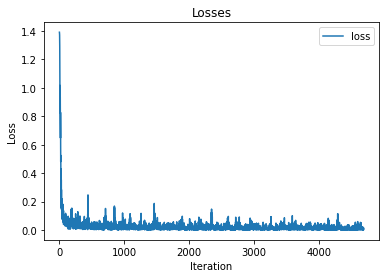

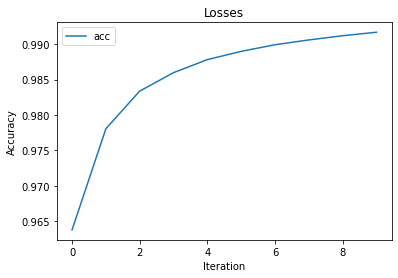

In [ ]:
q2_results(q2)